In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sn
import xlrd
import operator
import math
import re
import openpyxl
from collections import Counter, defaultdict
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import datasets

import nltk
from nltk.corpus import stopwords
from nltk import bigrams

c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [3]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']

In [4]:
#df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,normal_text,stemmed_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorige week plaatsten werkgevers we...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter alleen al in de eerste drie maanden...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

In [5]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts().sort_index()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.sort_values().to_latex(header=False))
countdf

50PLUS           413
CDA             2216
ChristenUnie    1223
D66             2211
GroenLinks      1193
PVV             1880
PvdA            2269
PvdD             480
SGP              770
SP              2573
VVD             2157
Name: party, dtype: int64

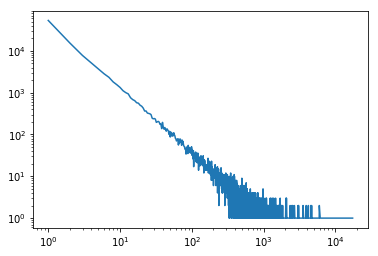

In [6]:
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

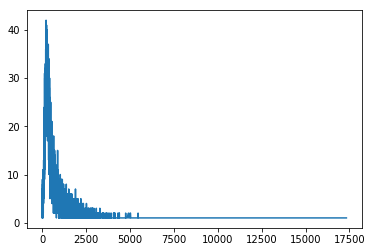

In [7]:
t = Counter([len(doc) for doc in list_text])
t = sorted(t.items())
x, y = zip(*t)
plt.plot(x, y)
plt.show()

# Baseline

In [8]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf.sum() for x in list(countdf)])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.04      0.04      0.04       413
         CDA       0.13      0.13      0.13      2216
ChristenUnie       0.08      0.08      0.08      1223
         D66       0.12      0.12      0.12      2211
  GroenLinks       0.07      0.07      0.07      1193
         PVV       0.10      0.10      0.10      1880
        PvdA       0.13      0.13      0.13      2269
        PvdD       0.02      0.02      0.02       480
         SGP       0.04      0.04      0.04       770
          SP       0.14      0.14      0.14      2573
         VVD       0.13      0.13      0.13      2157

 avg / total       0.11      0.11      0.11     17385



In [9]:
accuracy_score(df.party, np.full(len(df.party), 'SP'))

0.14800115041702616

# Models

In [10]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [12]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [13]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.96      0.86      0.91        84
         CDA       0.88      0.81      0.84       456
ChristenUnie       0.89      0.78      0.83       228
         D66       0.78      0.79      0.79       446
  GroenLinks       0.89      0.77      0.82       214
         PVV       0.83      0.91      0.87       374
        PvdA       0.76      0.76      0.76       476
        PvdD       0.96      0.86      0.91       101
         SGP       0.88      0.87      0.88       175
          SP       0.79      0.86      0.82       496
         VVD       0.74      0.80      0.77       427

 avg / total       0.82      0.82      0.82      3477



In [15]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,lid ouwehand naar,sgp,sp,de vvd
1,lid krol,het cda,christenunie,leden van veldhoven,lid van tongeren,de pvv,pvda,het lid ouwehand,de sgp,de sp,vvd
2,lid krol naar,cda fractie,lid dik faber,mijn fractie,leden van tongeren,islamitische,de partij van,lid ouwehand,leden van der,sp fractie,vvd fractie
3,het lid krol,de cda fractie,het lid dik,lid van veldhoven,lid voortman,klever,de arbeid,ouwehand naar mij,sgp fractie,de sp fractie,de vvd fractie
4,krol naar mij,de cda,lid dik,d66 is,het lid voortman,graus,van de arbeid,ouwehand naar,de leden dijkgraaf,smaling,de vvd is
5,krol naar,lid omtzigt,de leden voordewind,lid van meenen,lid voortman naar,madlener naar mij,arbeid,voor de dieren,leden dijkgraaf,lid van gerven,vvd is
6,van 50plus,het lid omtzigt,leden voordewind,van veldhoven,de leden voortman,madlener naar,partij van de,ouwehand,de sgp fractie,het lid smaling,voor de vvd
7,gepensioneerden,lid omtzigt naar,leden segers,veldhoven,leden voortman,natuurlijk,partij van,de dieren,mevrouw de voorzitter,lid smaling,wat de vvd
8,50plus is,omtzigt naar mij,de leden segers,d66 wil,voortman,de pvv is,pvda fractie,thieme,de leden bisschop,lid smaling naar,de vvd betreft
9,krol,omtzigt naar,leden dik,d66 vindt,tongeren,pvv fractie,de pvda fractie,dieren,leden bisschop,lid leijten,vvd betreft


In [16]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

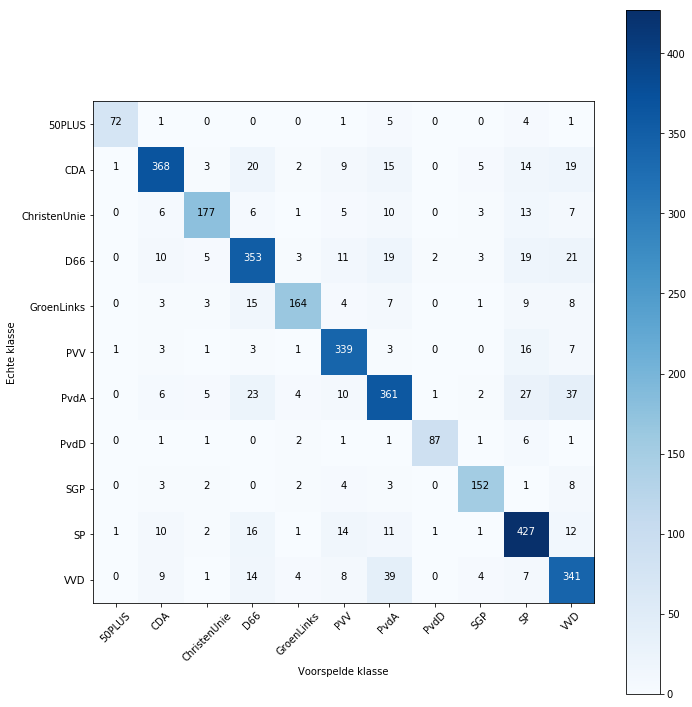

In [17]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [18]:
partijnamen = list(df.party.unique()) + ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie"]
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
df['withoutnames'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df.head(5)

,surname,party,text,file,speech category,date,tags,normal_text,stemmed_text,withoutnames
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorige week plaatsten werkgevers we...,voorzitter vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter alleen al in de eerste drie maanden...,voorzitter alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...


In [19]:
kamerlidnamen

re.compile(r"Wilders|Roemer|Pechtold|Van Haersma Buma|Thieme|Slob|Samsom|Van Ojik|Van der Staaij|Zijlstra|Krol|Van Bommel|Klaver|Schouten|Verheijen|Bisschop|Madlener|Servaes|Segers|Ulenbelt|Van Toorenburg|Berndsen-Jansen|Bosma|Litjens|Tanamal|Karabulut|Voortman|Kuzu|Voordewind|Fritsma|Gesthuizen|Van Hijum|Schouw|Kooiman|Helder|Van der Steur|Van Tongeren|Klein|Marcouch|Verhoeven|Monasch|Paulus Jansen|Koolmees|Visser|Van Weyenberg|Agnes Mulder|Leijten|De Rouwe|Tony van Dijck|Van Veldhoven|Bashir|Elias|Dik-Faber|De Graaf|Kuiken|Pia Dijkstra|Bruins Slot|Van Veen|Klever|Sjoerdsma|Bergkamp|Jasper van Dijk|Venrooy-van Ark|Keijzer|Nijboer|Merkies|Aukje de Vries|Harbers|Dijkgraaf|Groot|Dikkers|Van Gerven|De Liefde|Geurts|Ouwehand|Graus|Houwers|Van Meenen|Lucas|Rog|Mohandis|Wolbert|Anne Mulder|Straus|Jadnanansing|Beertema|Smaling|Ypma|Lodders|Jan Vos|Van Raak|Taverne|Heijnen|Agema|Van Vliet|Omtzigt|Mei Li Vos|Van Klaveren|Yücel|Azmani|Bosman|Jacobi|Hachchi|Knops|Albert de Vries|Van der Linde|Lee

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

In [ ]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push